In [1]:


# basic packages
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")

# deep learning packages
import torch
import torch.nn as nn

#Shared/Utility scripts
import sys
sys.path.insert(0, '../..')  #sys allows for the .ipynb file to connect to the shared folder files
from shared_scripts import Simple_Eval, dataloader, lstm_model

#load access key
HOME = os.path.expanduser('~')

Device: cuda


In [2]:
modelname = 'LSTM'
model_path = f"{HOME}/NWM_ML/Model/{modelname}"

cfsday_AFday = 1.983

#input columns
input_columns =[
                # 'Lat', 
                # 'Long', 
                'Drainage_area_mi2', 
                'Mean_Basin_Elev_ft',       
                'Perc_Forest', 
                # 'Perc_Develop', 
                # 'Perc_Imperv', 
                # 'Perc_Herbace',       
                # 'Perc_Slop_30', 
                'Mean_Ann_Precip_in', 
                's1',       
                's2', 
                'storage', 
                'swe', 
                'NWM_flow', 
                'DOY', 
                'tempe(F)', 
                'precip(mm)'
                ]

target = ['flow_cfs']


test_years = [2019, 2020]                 

#load data
datapath = f"{HOME}/NWM_ML/Data/input"
trainingfile = "final_input.parquet"
# trainingfile = "GSL_NWM_NWIS_dataset.parquet"

df, StreamStats = dataloader.get_ML_Data(datapath, trainingfile)
df.head()

df needs no processing


,station_id,Lat,Long,Drainage_area_mi2,Mean_Basin_Elev_ft,Perc_Forest,Perc_Develop,Perc_Imperv,Perc_Herbace,Perc_Slop_30,...,datetime,flow_cfs,s1,s2,storage,swe,NWM_flow,DOY,tempe(F),precip(mm)
0,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,...,2010-10-28,78.55521,-0.891007,-0.453991,0.0,1.2,55.0,301,39.239582,0.0
1,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,...,2010-10-29,98.61146,-0.891007,-0.453991,0.0,1.2,55.0,302,45.068712,0.0
2,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,...,2010-10-30,97.60208,-0.891007,-0.453991,0.0,1.1,54.0,303,50.945891,0.0
3,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,...,2010-10-31,99.33125,-0.891007,-0.453991,0.0,1.2,54.0,304,45.480097,0.0
4,10011500,40.965225,-110.853508,174.0,9720.0,67.7,1.2,0.12,2.94,27.2,...,2010-11-01,95.76354,-0.998630,0.052336,0.0,1.2,54.0,305,46.656777,0.0


## Dataprocessing
* Editing the features based on the feature importance
* Remove headwater stations from dataset
* make sure dates are in datetime format

### Data scaling

Scaling your data for ML is done for all types of applications and helps the model converge faster. 
If there is no scaling performed, the model will essentially be forced to think certain features are more important than others, rather than being able to learn those things.

There are different ways you can scale the data, such as min-max or standard scaling; both of which are applicable for your model. 
If you know you have a fixed min and max in your dataset (e.g. images), you can use min-max scaling to fix your input and/or output data to be between 0 and 1.

For other applications where you do not have fixed bounds, standard scaling is useful.
This gives all of your features zero-mean and unit variance. Therefore, the distributions of inputs and/or outputs are the same, and the model can treat them as such.

The scaling for your outputs is important in defining the activation function for the output layer.
If you have min-max scaled outputs, you can use sigmoid, because it bounds the outputs to between 0 and 1. 
If you are using standard scaling for the outputs, you would want to be sure you use a linear activation function, because technically standard-scaled outputs are not bounded. 
The choice of output activation is important, and knowledge of how your outputs are scaled is important in determining which activation to use.

In [3]:
#get non headwater stations
headwater_stations = ['10011500', # Bear River headwaters before WY state line
                      '10109000', # Logan River above dams
                      '10113500', # HW Blacksmith fork
                      '10128500', # Upper Weber above Oakley
                      '10131000', #Chalk creek before Weber - lots of upstream irrigation, potentially include
                        '10146400', #Currant Creek above Mona Reservoir - lots of upstream irrigation, potentially include
                        '10150500', #Spanish fork after diamond fork - potentially include because of 6th water diversion CUP
                        '10154200', #Upper Provo river after confluence of N/S forks - potentially include because of duchense tunnel water diversion CUP
                        '10172700', #Vernon creek 2 ranges west of Utah Lake, shouldnt be included because not in GSL basin 
                        '10172800', #Willow creek west of Gransville,  shouldnt be included because does not make it to GSL
                          '10172952'
                          ] #Dunn creek in Raft River Range, shouldnt be included because drains to bonnevile salt flats 

#remove headwater stations
df = df[~df['station_id'].isin(headwater_stations)]

#get stations with correct swe and storage features
#The following sites have swe 

'''
['10011500', '10105900', '10109000', '10126000', '10131000',
       '10133650', '10133800', '10133980', '10134500', '10136500',
       '10140700', '10141000', '10150500', '10154200', '10155000',
       '10155200']
'''

#the following sites have swe and storage
'''
['10126000', '10134500', '10136500', '10140700', '10141000',
       '10155200']
'''

stations = df['station_id'][(df['swe']>0) & (df['storage']>0)].unique()
#stations = ['10155000']

#Train model with these stations
df = df[df['station_id'].isin(stations)]

df.head()

,station_id,Lat,Long,Drainage_area_mi2,Mean_Basin_Elev_ft,Perc_Forest,Perc_Develop,Perc_Imperv,Perc_Herbace,Perc_Slop_30,...,datetime,flow_cfs,s1,s2,storage,swe,NWM_flow,DOY,tempe(F),precip(mm)
16765,10126000,41.576321,-112.100782,7040.0,6620.0,15.6,4.28,0.55,15.2,1.94,...,2010-10-28,1162.60410,-0.891007,-0.453991,34.071895,1.142857,1183.0,301,41.423048,0.0
16766,10126000,41.576321,-112.100782,7040.0,6620.0,15.6,4.28,0.55,15.2,1.94,...,2010-10-29,1152.39590,-0.891007,-0.453991,34.673203,1.128571,1181.0,302,52.055238,0.0
16767,10126000,41.576321,-112.100782,7040.0,6620.0,15.6,4.28,0.55,15.2,1.94,...,2010-10-30,1036.51040,-0.891007,-0.453991,35.346405,1.071429,1181.0,303,51.981724,0.0
16768,10126000,41.576321,-112.100782,7040.0,6620.0,15.6,4.28,0.55,15.2,1.94,...,2010-10-31,680.29170,-0.891007,-0.453991,36.039216,1.078571,1179.0,304,43.891912,0.0
16769,10126000,41.576321,-112.100782,7040.0,6620.0,15.6,4.28,0.55,15.2,1.94,...,2010-11-01,557.59375,-0.998630,0.052336,36.699346,1.100000,1175.0,305,45.246638,0.0


## Train the model
* make the model a .py file and class when finalized. PyTorch only saves the weights of the layer/node, not the overall structure.

In [61]:
import importlib
importlib.reload(lstm_model)

Device: cuda


<module 'shared_scripts.lstm_model' from '/home/rjohnson18/NWM_ML/RJ/ModelDevelopment/../../shared_scripts/lstm_model.py'>

Optimizing the LSTM model by evaluating 75 models using grid search validation
StandardScaler applied
Training 1 of 75 models
Lookback: [10, 20, 30, 40, 65]
feature shape: torch.Size([26029, 10, 12]), Test shape: torch.Size([26029])
Epochs: 50, Batch size: 100, LR: 0.0001, Decay: 0.0005, Neurons: 50, Number Layers: 1, Bidirectional: True
Bidirectional: True


Epochs completed:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0: train RMSE 2.4176, test RMSE 0.4544
Epoch 10: train RMSE 2.1383, test RMSE 0.4955
Epoch 20: train RMSE 1.9924, test RMSE 0.5840
Epoch 30: train RMSE 2.0135, test RMSE 0.6524
Epoch 40: train RMSE 2.0537, test RMSE 0.6860


Epochs completed:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0: train RMSE 2.5916, test RMSE 0.7166
Epoch 10: train RMSE 2.7201, test RMSE 0.7982
Epoch 20: train RMSE 2.7972, test RMSE 0.8016
Epoch 30: train RMSE 2.8459, test RMSE 0.7994
Epoch 40: train RMSE 2.8855, test RMSE 0.8051


Epochs completed:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0: train RMSE 0.2799, test RMSE 0.8072
Epoch 10: train RMSE 0.1534, test RMSE 0.7547
Epoch 20: train RMSE 0.1339, test RMSE 0.7413
Epoch 30: train RMSE 0.1312, test RMSE 0.7361
Epoch 40: train RMSE 0.1305, test RMSE 0.7333


Epochs completed:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0: train RMSE 0.1283, test RMSE 0.7316
Epoch 10: train RMSE 0.1265, test RMSE 0.7320
Epoch 20: train RMSE 0.1279, test RMSE 0.7319
Epoch 30: train RMSE 0.1290, test RMSE 0.7315
Epoch 40: train RMSE 0.1295, test RMSE 0.7311


Epochs completed:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0: train RMSE 0.1346, test RMSE 0.7299
Epoch 10: train RMSE 0.1276, test RMSE 0.7243
Epoch 20: train RMSE 0.1251, test RMSE 0.7221
Epoch 30: train RMSE 0.1235, test RMSE 0.7206
Epoch 40: train RMSE 0.1224, test RMSE 0.7193


Epochs completed:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0: train RMSE 0.1581, test RMSE 0.7179
Epoch 10: train RMSE 0.1588, test RMSE 0.7154
Epoch 20: train RMSE 0.1584, test RMSE 0.7137
Epoch 30: train RMSE 0.1580, test RMSE 0.7123
Epoch 40: train RMSE 0.1576, test RMSE 0.7110


Epochs completed:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0: train RMSE 0.1050, test RMSE 0.7097
Epoch 10: train RMSE 0.1019, test RMSE 0.7045
Epoch 20: train RMSE 0.1012, test RMSE 0.7020
Epoch 30: train RMSE 0.1007, test RMSE 0.6999
Epoch 40: train RMSE 0.1004, test RMSE 0.6979


Epochs completed:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0: train RMSE 0.3540, test RMSE 0.6770
Epoch 10: train RMSE 0.2827, test RMSE 0.6097
Epoch 20: train RMSE 0.2721, test RMSE 0.5908
Epoch 30: train RMSE 0.2677, test RMSE 0.5806
Epoch 40: train RMSE 0.2656, test RMSE 0.5739


Epochs completed:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0: train RMSE 0.6236, test RMSE 0.5774
Epoch 10: train RMSE 0.7396, test RMSE 0.6755
Epoch 20: train RMSE 0.7541, test RMSE 0.6920
Epoch 30: train RMSE 0.7594, test RMSE 0.6970
Epoch 40: train RMSE 0.7627, test RMSE 0.6997
Model training took: 21.83361498499994  seconds
Training Complete
Bidirectional: True
model is on cuda
USGS site: 10126000


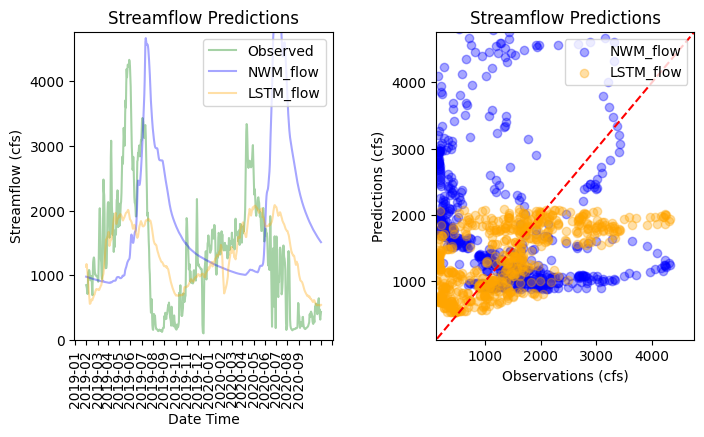

,NWM_flow_kge,LSTM_flow_kge,NWM_flow_rmse,LSTM_flow_rmse,NWM_flow_mape,LSTM_flow_mape,NWM_flow_pbias,LSTM_flow_pbias
station_id,,,,,,,,
10136500,-0.42,0.55,644.0,247.0,330.76,78.64,-137.08,5.58
10126000,-0.31,0.36,1716.0,766.0,306.30,119.06,-39.65,0.08
10140700,0.29,0.33,236.0,262.0,221.61,298.37,-30.30,-39.48
10141000,-2.10,0.13,1169.0,421.0,1111.22,354.03,-304.72,-82.58
10155200,0.63,-0.27,192.0,355.0,29.28,63.87,15.23,71.78
10134500,-0.97,-0.39,132.0,93.0,545.15,363.91,-173.33,-127.20


Training 2 of 75 models
Lookback: [10, 20, 30, 40, 65]
feature shape: torch.Size([26029, 10, 12]), Test shape: torch.Size([26029])
Epochs: 50, Batch size: 100, LR: 0.0001, Decay: 0.0005, Neurons: 100, Number Layers: 1, Bidirectional: True
Bidirectional: True


Epochs completed:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0: train RMSE 2.3533, test RMSE 0.4648
Epoch 10: train RMSE 2.0021, test RMSE 0.5286
Epoch 20: train RMSE 2.0151, test RMSE 0.6245
Epoch 30: train RMSE 2.0842, test RMSE 0.6653
Epoch 40: train RMSE 2.1511, test RMSE 0.6961


Epochs completed:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0: train RMSE 2.7294, test RMSE 0.7607
Epoch 10: train RMSE 2.8925, test RMSE 0.8253
Epoch 20: train RMSE 2.9362, test RMSE 0.8051
Epoch 30: train RMSE 2.9758, test RMSE 0.7959
Epoch 40: train RMSE 3.0112, test RMSE 0.7921


Epochs completed:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0: train RMSE 0.2650, test RMSE 0.7845
Epoch 10: train RMSE 0.1675, test RMSE 0.7401
Epoch 20: train RMSE 0.1535, test RMSE 0.7331
Epoch 30: train RMSE 0.1460, test RMSE 0.7299
Epoch 40: train RMSE 0.1412, test RMSE 0.7274


Epochs completed:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0: train RMSE 0.1342, test RMSE 0.7258
Epoch 10: train RMSE 0.1314, test RMSE 0.7270
Epoch 20: train RMSE 0.1329, test RMSE 0.7269
Epoch 30: train RMSE 0.1334, test RMSE 0.7266
Epoch 40: train RMSE 0.1332, test RMSE 0.7261


Epochs completed:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0: train RMSE 0.1425, test RMSE 0.7238
Epoch 10: train RMSE 0.1317, test RMSE 0.7132
Epoch 20: train RMSE 0.1278, test RMSE 0.7099
Epoch 30: train RMSE 0.1256, test RMSE 0.7078
Epoch 40: train RMSE 0.1241, test RMSE 0.7062


Epochs completed:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0: train RMSE 0.1609, test RMSE 0.7045
Epoch 10: train RMSE 0.1601, test RMSE 0.7012
Epoch 20: train RMSE 0.1593, test RMSE 0.6989
Epoch 30: train RMSE 0.1587, test RMSE 0.6967
Epoch 40: train RMSE 0.1583, test RMSE 0.6947


Epochs completed:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0: train RMSE 0.1028, test RMSE 0.6916
Epoch 10: train RMSE 0.1028, test RMSE 0.6843
Epoch 20: train RMSE 0.1024, test RMSE 0.6820
Epoch 30: train RMSE 0.1020, test RMSE 0.6794


In [63]:
#Train the model
# Assuming you have your data loaded into NumPy arrays as x_train_scaled, y_train_scaled, x_test_scaled, y_test_scaled, x_scaled, y_scaled
# parameters   - need to be able to put the lookback in here...
epochs = [50,80,100,200,300] #early stopping - Savalan is lookin into it
lookback = [10,20,30,40,65]
batch_size = [100]
learning_rate = [0.0001] #initial rate
decay = [0.0005] #reduces to 
neurons = [50,100,150]
num_layers = [1]
bidirectional = [True]
supply = False
loss_func = nn.MSELoss()
scalertype =  'StandardScaler' #'MinMaxScaler'
plot = False

training_params = epochs, lookback, batch_size, learning_rate, decay, neurons, num_layers, bidirectional

GS_Eval_DF, GS_Eval_dict, GS_Pred_dict = lstm_model.LSTM_optimization(df, 
                    input_columns, 
                    target, 
                    test_years, 
                    model_path,
                    scalertype,
                    training_params,
                    loss_func,
                    modelname,
                    StreamStats,
                    supply,
                    plot)

GS_Eval_DF

In [ ]:
GS_Eval_DF

# Finalize automatic training protocol for final model.
Make a prediction for each location, save as compressed pkl file, and send predictions to AWS for use in CSES

In [ ]:
#convert the MLP final model to lstm

Eval_DF, Preds_Dict = lstm_model.Final_Model(df,
                GS_Eval_DF,
                input_columns,
                target,
                loss_func, 
                scalertype,
                model_path, 
                modelname,
                test_years, 
                StreamStats,
                supply
                )
Eval_DF

In [ ]:
import importlib
importlib.reload(lstm_model)

In [ ]:
#Manually train the model
# Assuming you have your data loaded into NumPy arrays as x_train_scaled, y_train_scaled, x_test_scaled, y_test_scaled, x_scaled, y_scaled
# Hyperparameters
epochs = 5 #early stopping - Savalan is lookin into it
batch_size = 65
learning_rate = 0.00001 #initial rate
decay = 0.0005 #reduces to 
validation_split = 0.2  #can add cross validation - Savalan is looking into it.
neurons = 300
shuffle = True
bidirectional = True
input_shape = x_train_scaled_t.shape[2]

training_params = epochs, batch_size, learning_rate, decay, neurons, bidirectional
model_params = bidirectional, input_shape, neurons

lstm_model.LSTM_train(training_params,
            x_train_scaled_t,
            y_train_scaled_t, 
            shuffle, 
            model_path,
            modelname)

Preds_Dict = lstm_model.LSTM_predict(model_params, 
                        test_years, 
                        df, 
                        X_test_dic, 
                        input_shape, 
                        StreamStats, 
                        model_path, 
                        modelname)

#Evaluate model performance of the different models, 'flow_cfs_pred', 
prediction_columns = ['NWM_flow', f"{modelname}_flow"]
Eval_DF = Simple_Eval.Simple_Eval(Preds_Dict, 
                                prediction_columns, 
                                modelname, 
                                supply = supply,
                                plots = False, 
                                keystats = False        
                                )

#create dataframe to store key model perf metrics, and inputs
cols = [f"{modelname}_flow_kge", f"{modelname}_flow_rmse", f"{modelname}_flow_mape", f"{modelname}_flow_pbias"]
model_eval = Eval_DF[cols].copy()

#Get mean scoring metrics for AOI - aver kge, mape, pbias
model_eval = pd.DataFrame(model_eval.mean(axis=0)).T